# <font color=black>Machine Learning Algorithm to Detect Potential Bike Share Demand

Written in January 2023 by ZMS. Looks to use historic data to train and test a model built to look at the bike share demand during given conditions.

## <font color=blue>Libraries

In [130]:
#general libraries
import pandas as pd
import numpy as np
import math
import os
import datetime

#plotting mods
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import FixedLocator, FixedFormatter

#tensor flow and keras for neural networking
import tensorflow as tf
from tensorflow import keras
from scikeras.wrappers import KerasClassifier, KerasRegressor

#sklearn modules for preprocessing and transformation
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, StandardScaler, OrdinalEncoder, PowerTransformer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, mean_absolute_error

## <font color=blue>Function Definitions

In [132]:
from sklearn.model_selection import learning_curve

def plot_learning_curve1(estimator,X,y,ylim=None,cv=None,n_jobs=None,train_sizes=np.linspace(0.1, 1.0, 20),scoring = 'neg_root_mean_squared_error'):
    
    _, axes = plt.subplots(1, 1, figsize=(10, 5))    
    axes.set_title('Learning Curve')
    if ylim is not None:
        axes.set_ylim(*ylim)
    axes.set_xlabel("Training examples")
    axes.set_ylabel(scoring)

    train_sizes, train_scores, test_scores= learning_curve(estimator,X,y,cv=cv,n_jobs=n_jobs,train_sizes=train_sizes,scoring = scoring)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Plot learning curve
    axes.grid()
    axes.fill_between(train_sizes,train_scores_mean - train_scores_std,train_scores_mean + train_scores_std,alpha=0.1,color="r")
    axes.fill_between(train_sizes,test_scores_mean - test_scores_std,test_scores_mean + test_scores_std,alpha=0.1,color="g")
    axes.plot(train_sizes, train_scores_mean, "o-", color="r", label="Training score")
    axes.plot(train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score")
    axes.legend(loc="best")
    plt.show()
    
    return

#function provided that plots the learning curve for neural networks
def plot_learning_curve( history ):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    ymin, ymax = [], []
    for x in history.history.keys():
        ymax.append( max(history.history[x]))
        ymin.append( min(history.history[x]))
    plt.gca().set_ylim(min(ymin)*.95, max(ymax)*1.05)
    plt.xlabel("EPOCHS")
    plt.show()


## <font color=blue>Import Data

In [178]:
path = '/Users/zoespiegelhoff/Downloads'
os.chdir(path)
data = pd.read_csv('train.csv')

In [179]:
data.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


## <font color=blue>Data Cleansing & Manipulation

In [181]:
##need to manipulate the date to a readable form in terms of day, month, year and hour
#is date a datetime?
data.dtypes

datetime    object
count        int64
dtype: object

In [183]:
#change date to datetime
data['datetime']= pd.to_datetime(data['datetime'])

In [185]:
##split all into month/day/year/hr
#splitting date
data["month"] = (
    data['datetime'].dt.month
)
data["year"] = (
    data['datetime'].dt.year
)
data["day"] = (
    data['datetime'].dt.day
)
data["hour"] = (
    data['datetime'].dt.hour
)

In [186]:
#drop datetimes
data.drop(columns=['datetime'], inplace=True)

In [187]:
#split the dataset
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(columns=['count']),
    data['count'], 
    random_state=32
)

X_train.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,month,year,day,hour
1462,2,0,1,1,20.50,24.240,31,19.9995,36,196,4,2011,6,19
6857,2,0,1,1,18.86,22.725,59,0.0000,0,11,4,2012,4,1
8087,2,0,0,1,22.96,26.515,68,16.9979,24,95,6,2012,17,8
2561,2,0,1,1,26.24,31.060,47,11.0014,42,136,6,2011,14,15
2926,3,0,0,1,31.16,34.850,55,12.9980,101,167,7,2011,10,20


In [188]:
#discern between attribs
cat_attribs = ["season", "holiday", "workingday", "weather"]
num_attribs = list( X_train.drop(columns=cat_attribs) )

#create pipeline
num_pipeline = Pipeline( [
 ('imputer', SimpleImputer(strategy="median")),
 ('std_scaler', StandardScaler()),   
])

full_pipeline = ColumnTransformer( [
    ('num', num_pipeline, num_attribs),
    ('cat', OneHotEncoder(), cat_attribs)
])

#pipeline X train and X test
X_train = full_pipeline.fit_transform(X_train)

X_test = full_pipeline.transform(X_test)

X_train.shape, X_test.shape

((8164, 22), (2722, 22))

## <font color=blue>Establish a Baseline RMSE

In [189]:
#baseline determination
baseline_prediction = y_train.median()
predictions = np.full(shape=8164, fill_value = baseline_prediction)
baseline_rmse = mean_squared_error(y_train, predictions, squared=False)
print(baseline_rmse)

186.6973438795018


## <font color=blue>Linear Regression

In [190]:
#linear regression
lin_reg = LinearRegression()
lin_reg.fit(X_train,y_train)
predictions = lin_reg.predict(X_train)
lin_rmse = mean_squared_error(y_train, predictions, squared=False)
print(lin_rmse)

2.0822180721659675e-13


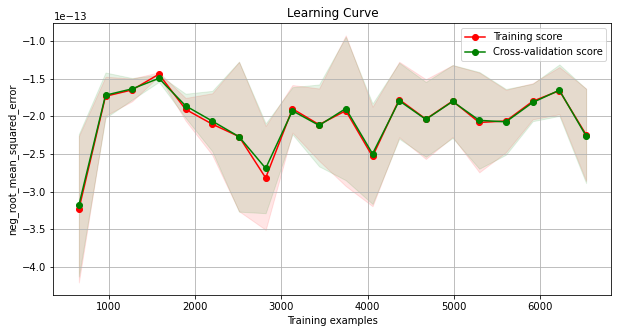

In [191]:
plot_learning_curve1(lin_reg, X_train, y_train)

In [194]:
#eval test set
predictions = lin_reg.predict(X_test)
linreg_mse = mean_squared_error(y_test, predictions, squared=False)
print(linreg_rmse)
acc = lin_reg.score(X_train, y_train)
print('Accuracy: {:.2f}%'.format(acc*100))

4.585590429037783e-07
Accuracy: 100.00%
